# Population time series analysis

In this project, we will look at predicting the population numbers using ARIMA modelling. Throughout the project, we will break down the ARIMA model into the testing the assumptions, performing order selection and fitting the model.

### Import the required libraries and modules

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

### Import and manipulate the data

In [66]:
df = pd.read_csv(r"C:\Users\pjhop\OneDrive\Documents\Programming & Coding\Python\Projects\Datasets\POP.csv", index_col=False)
df = df.drop(['realtime_start', 'realtime_end'], axis=1)

In [67]:
df.head()

,value,date
0,156309.0,1952-01-01
1,156527.0,1952-02-01
2,156731.0,1952-03-01
3,156943.0,1952-04-01
4,157140.0,1952-05-01


In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 816 entries, 0 to 815
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   816 non-null    float64
 1   date    816 non-null    object 
dtypes: float64(1), object(1)
memory usage: 12.9+ KB


When looking at the info, we can see that the date column has the datatype being in the `object` datatype rather than in the datetime format. We will update this using the below code.

In [69]:
# Updating to datetime and specifying date format
date_format = "%Y-%m-%d"
df['date'] = pd.to_datetime(df['date'], format=date_format)
df.set_index("date", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 816 entries, 1952-01-01 to 2019-12-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   816 non-null    float64
dtypes: float64(1)
memory usage: 12.8 KB


We can see that the dtype has updated to `datetime64` amd is now our index. 

In [70]:
df.shape

(816, 1)

### Visualise the dataset

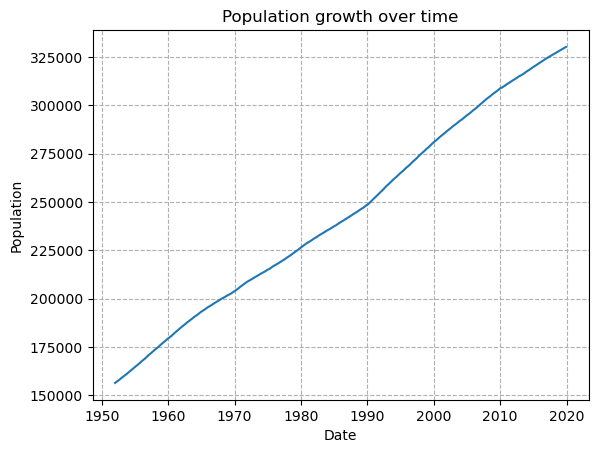

In [71]:
sns.lineplot(x='date', y='value', data=df)

plt.xlabel("Date")
plt.ylabel("Population")
plt.title("Population growth over time")
plt.grid(linestyle="--")
plt.show()

## Model building

The ARIMA model builds on simpler time series analysis methods, such as the AR, MA and ARMA models. It still maintains the autoregressive feature with lagged variables contributing to the prediction, as well as the moving average error terms which carry over prediction errors into new forecasts. For example, say an analyst worked for a water company to predict customer usage patterns over time and then the area which they provided water for had a new event on. This would not be captured by the data and would likely mean the model would have minor errors in the numbers. This model would carry over these errors and factor them into new predictions (MA part of the model). 

These techniques are combined in the ARMA model, but this model requires that the data be stationary, which means the data has to follow a set of conditions:

1. Constant mean
2. Constant variance
3. Constant autocovariance

The ARIMA model builds on this model, but instead focuses on differentiating the data to achieve stationarity. In this section, we are going to check the orders of the integrating, moving average and autoregressive terms by looking at diagnostic plots and performing statistical tests such as the ADF test.

### Seasonality

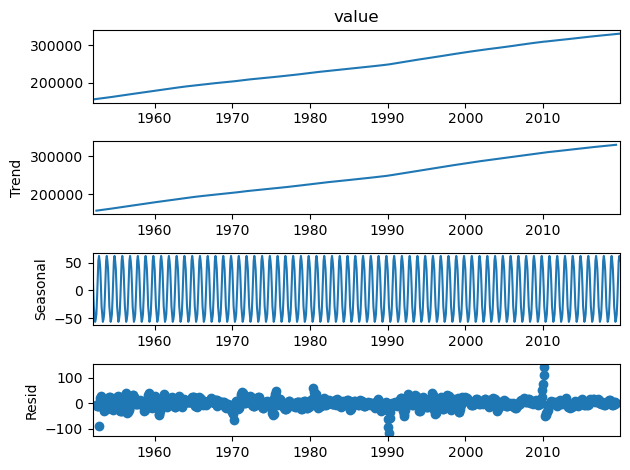

In [72]:
decomposed = seasonal_decompose(df["value"])
x = decomposed.plot()

### Stationarity

In [73]:
def stationarity_test(df):
    adf = adfuller(df)
    test_stats = adf[0]
    p_value = adf[1]
    print(f"Test statistic: {test_stats:,.3f}")
    print(f"P-value: {p_value:,.3f}")
    if p_value < 0.05:
        print("Null hypothesis of rejected. The data is stationary.")
    else:
        print("Null hypothesis is accepted. The data is non-stationary")

#### First differenced

In [74]:
df["first_diff"] = df["value"].diff()
df.dropna(subset=["first_diff"], inplace=True)

In [75]:
stationarity_test(df["first_diff"])

Test statistic: -2.010
P-value: 0.282
Null hypothesis is accepted. The data is non-stationary


#### Second differenced

In [76]:
df["second_diff"] = df["first_diff"].diff()
df.dropna(subset=["second_diff"], inplace=True)

In [77]:
stationarity_test(df["second_diff"])

Test statistic: -7.221
P-value: 0.000
Null hypothesis of rejected. The data is stationary.


#### TSA plots

In this section, we will use the acf and pacf to identify the lags for the AR and MA parts of the model.

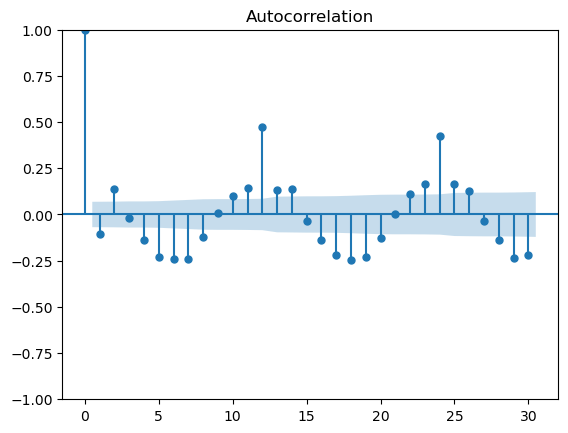

In [80]:
plot_acf(df["second_diff"])
plt.show()

When looking at this acf, the negative lags are a sign that despite the data being stationary it has been over differenced and hence we will change and use the first differenced data.

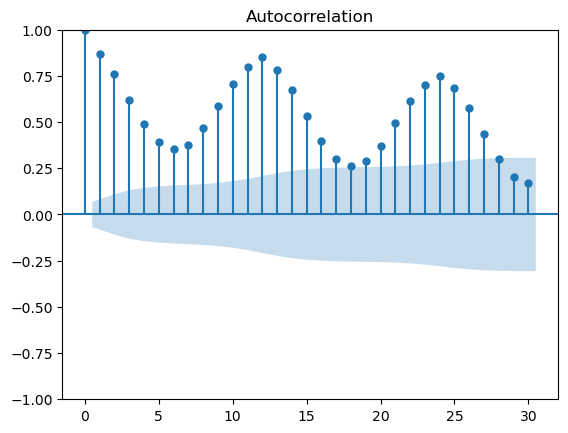

In [79]:
plot_acf(df["first_diff"])
plt.show()

### Identifying the AR lag order

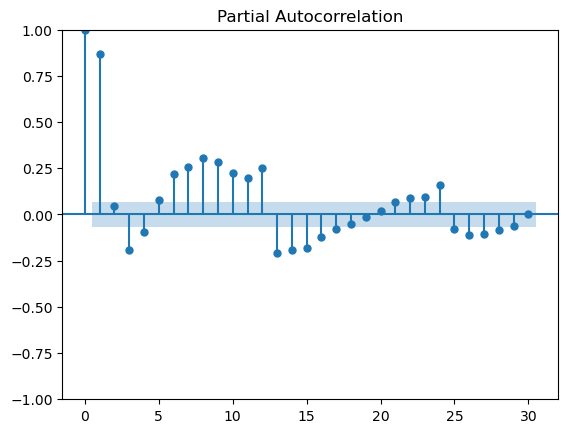

In [83]:
plot_pacf(df["first_diff"])
plt.show()

From the graph, we choose a order value of 1.

### Identifying the MA lag order

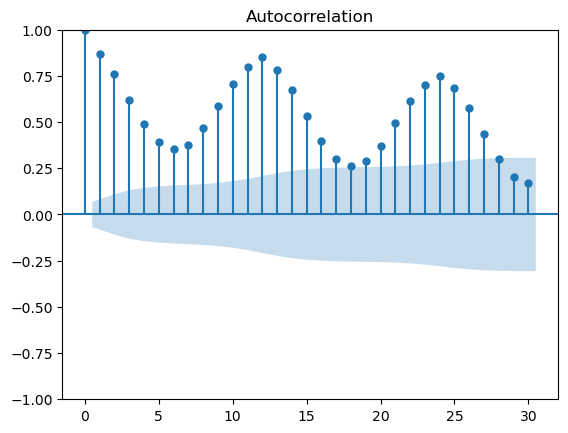

In [84]:
plot_acf(df["first_diff"])
plt.show()

From the graph, I can going to select a MA lag order value of 6 after which there seems to be a repeating time trend.

### ARIMA 

Here, we fit our model with our preferred order selection values.

In [96]:
from statsmodels.tsa.arima.model import ARIMA

In [107]:
model = ARIMA(df["value"], order=(1, 1, 5))
res = model.fit()

C:\Users\pjhop\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\pjhop\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\pjhop\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\pjhop\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [108]:
print(res.summary())

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  814
Model:                 ARIMA(1, 1, 5)   Log Likelihood               -3627.000
Date:                Mon, 24 Jul 2023   AIC                           7268.000
Time:                        23:23:53   BIC                           7300.905
Sample:                    03-01-1952   HQIC                          7280.631
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9983      0.001   1835.867      0.000       0.997       0.999
ma.L1         -0.3179      0.013    -24.337      0.000      -0.344      -0.292
ma.L2          0.0083      0.029      0.283      0.7

We haven't compared any models here, however when selecting models you would typically use a range of the values above to compare the models:
1. AIC/BIC - lower values indicate a better performing model.
2. Ljung-Box test - used to analyse autocorrelation
3. Assess coefficient significance - p-values less than 0.05 indicate good performance (null hypothesis rejected).
4. Prob(H) values - greater than 0.05 indicates there is no significant heteroskedasticity in the residuals.

There are other ways to check the performance, you can split the dataset into a training and test set then compared the performance.